# 2-Layer Bayesian Neural Network with NumPy
This notebook trains a 2 layer neural network on the [MNIST digit recognizer set](https://www.kaggle.com/competitions/digit-recognizer/data). The purpose of this notebook is to have a simple starting point to use building a Bayesian neural network using variaional inference. Also, this neural network is built without using PyTorch, instead all functions are defined using NumPy so that the mathematical steps are fully shown.


## Data Setup

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# import the data (MNIST)
data = pd.read_csv('/Users/kelseychen/Downloads/digit-recognizer/train.csv')

The data contains images of hand drawn digits between 0-9 that are 28x28 pixels each with a pixel value btween 0-255 to denote the shade of the pixel. Here 0 represents white and 255 represents black. 

The neural network will have two layer architecure where the input layer has 784 neurons. The hiden layer uses ReLU activation and the final layer uses softmax activation. 

In [3]:
# convert the data to np array
data = np.array(data)
m, n = data.shape

# shuffle the data before splitting into training and test sets
np.random.shuffle(data)

# split the data
data_test = data[0:1000].T
Y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255. # normalize 

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255. # normalize 

_,m_train = X_train.shape

In [4]:
Y_train

array([7, 6, 1, ..., 2, 4, 4])

## Activation and Utility Functions

ReLU activation in the hidden layers of the network. The derivative of ReLu is used during backpropogation. 

Softmax is used to convert a vector of real numbers to a probability distribution and it used in the output layer of the network

One-hot is used to convert class labels to encoded vectors. This function s used to compute the loss during training.

In [5]:
def relu(Z):
    return np.maximum(0, Z)

def relu_deriv(Z):
    return Z > 0

def softmax(Z):
    Z -= np.max(Z, axis=0, keepdims=True)
    expZ = np.exp(Z)
    return expZ / np.sum(expZ, axis=0, keepdims=True)

def one_hot(Y, num_classes=10):
    return np.eye(num_classes)[Y].T

## Model Weights as Distributions

Below we initialize the variational parameters for each weight and bias in the neural network. For a Bayesian neural network, we assume each weight is a distribution instead of having the traditional fixed weights. In this case, we assume a normal distribution over the weights. To stabilize the calculations we will work with $$\mu$$ (the mean of the distribution) and $$log(\sigma)$$ (the log of the standard deviation).

In `sample weights` we sample the weights from the distribution by using the reparameterization trick. They are then used in the forward pass to calculate predictions. 

In [6]:
# use a Normal distribution 
def init_variational_params(input_dim, hidden_dim, output_dim):
    params = {}
    for name, shape in {
        'W1': (hidden_dim, input_dim),
        'b1': (hidden_dim, 1),
        'W2': (output_dim, hidden_dim),
        'b2': (output_dim, 1)
    }.items():
        # initialize the mean of each weight
        if 'W' in name:
            fan_in = shape[1]
            params[name + '_mu'] = np.random.randn(*shape) * np.sqrt(2. / fan_in)
        else:

            params[name + '_mu'] = np.zeros(shape)

        # initialize the log standard deviation 
        params[name + '_log_std'] = np.full(shape, -3.0)  # small std at first
    return params

In [7]:
def sample_weights(params):
    weights, eps_cache = {}, {}
    for key in ['W1', 'b1', 'W2', 'b2']:
        mu = params[key + '_mu']

        # convert to std
        std = np.exp(params[key + '_log_std'])

        # sample epsilon from N(0,1)
        eps = np.random.randn(*mu.shape)

        # sample w ~ N(mu, std^2)
        weights[key] = mu + std * eps
        eps_cache[key] = eps
    return weights, eps_cache

## Forward and Backwards Pass 

In the forward pass we want to compute the pre-activation input to the hidden layer that is 
$$
Z^{(1)} = W^{(1)}X+b^{(1)}
$$
where 
$$
W^{(1)} \in \mathbb R^{h\times d} \quad \text{ are the weights} 
$$
 
$$
X \in \mathbb  R^{d\times m} \quad \text{ are the input features} 
$$
 
$$
b^{(1)}) \in  R^{h\times 1} \quad \text{ is the bias vector}
$$

In [8]:
def forward(X, weights):
    Z1 = weights['W1'] @ X + weights['b1']

    # apply ReLU activation to introduce non-linearity 
    A1 = relu(Z1)

    # copute the pre-activation input
    Z2 = weights['W2'] @ A1 + weights['b2']
    
    # apply softmax activation to produce probabilities
    A2 = softmax(Z2)

    # save values to use in backprop
    cache = {'X': X, 'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
    return A2, cache

The function `backward` computes  
$$
\nabla_{\mu, \log \sigma} \mathrm{ELBO}
= \nabla_{\mu, \log \sigma}
\left[\, -\log p(y \mid x, w) \;+\; \mathrm{KL}(q(w)\,\|\,p(w)) \right],
$$  
where the first term corresponds to the negative log-likelihood and the second term is the KL divergence between the variational posterior $q(w)$ and a standard normal prior $ p(w) $.
1. Compute the gradient of the negative log-likelihood

Let  
$$
\hat{Y} = A^{(2)} \in \mathbb{R}^{k \times m}, \quad \text{(predicted probabilities)}
$$
$$
Y \in \mathbb{R}^{k \times m}, \quad \text{(one-hot encoded true labels)}
$$

Then the gradient of the loss with respect to the output logits is:
$$
dZ^{(2)} = \hat{Y} - Y
$$

2. Compute the gradients of the output weights and biases

Let $ m $ be the number of examples in the batch:
$$
\nabla_{W^{(2)}_\mu} = \frac{1}{m} dZ^{(2)} (A^{(1)})^T
$$
$$
\nabla_{b^{(2)}_\mu} = \frac{1}{m} \sum dZ^{(2)}
$$

3. Backpropagate to the hidden layer

Propagate the error backward:
$$
dA^{(1)} = (W^{(2)})^T dZ^{(2)}
$$
$$
dZ^{(1)} = dA^{(1)} \circ \text{ReLU}'(Z^{(1)})
$$

Then compute the gradients:
$$
\nabla_{W^{(1)}_\mu} = \frac{1}{m} dZ^{(1)} X^T
$$
$$
\nabla_{b^{(1)}_\mu} = \frac{1}{m} \sum dZ^{(1)}
$$

4. Add the KL divergence gradients

Assume the variational posterior:
$$
q(w) = \mathcal{N}(\mu, \sigma^2), \quad \text{with prior } p(w) = \mathcal{N}(0, 1)
$$

Then the gradients of the KL divergence term are:

- With respect to the mean $ \mu $:
$$
\nabla_{\mu} \mathrm{KL} = \frac{\mu}{m}
$$

- With respect to the log standard deviation$\log \sigma $, using $ \sigma = e^{\\log \sigma} $:
$$
\nabla_{\\log \sigma} \mathrm{KL} = \frac{1}{m} (\sigma^2 - 1)
$$

5. Include the reparameterization term

Since weights are sampled as:
$$
w = \mu + \sigma \cdot \epsilon,
$$

the derivative of the likelihood with respect to $\log \sigma$ includes:
$$
\nabla_{\log \sigma} \mathcal{L}_{\text{likelihood}} = \sigma \cdot \epsilon \cdot \nabla_{\mu} \mathcal{L}
$$



###  Final gradients used to update parameters

For each weight or bias:
$$
\nabla_{\mu} \mathcal{L}_{\text{ELBO}} = \nabla_{\mu} \mathcal{L}_{\text{likelihood}} + \frac{\mu}{m}
$$
$$
\nabla_{\log \sigma} \mathcal{L}_{\text{ELBO}} = \sigma \cdot \epsilon \cdot \nabla_{\mu} \mathcal{L}_{\text{likelihood}} + \frac{\sigma^2 - 1}{m}
$$

These gradients are returned and used to update the variational parameters during training.

In [9]:
# gradient computation using KL scaling
def backward(Y, cache, weights, eps_cache, params, m, kl_weight):
    grads = {}

    Y_hat = cache['A2']

    # compute the derivative of softmax
    dZ2 = Y_hat - Y  

    # backprop from output to hidden
    grads['W2_mu'] = (1/m) * dZ2 @ cache['A1'].T
    grads['b2_mu'] = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    # backprop through ReLu and hidden layer 
    dA1 = weights['W2'].T @ dZ2
    dZ1 = dA1 * relu_deriv(cache['Z1'])

    grads['W1_mu'] = (1/m) * dZ1 @ cache['X'].T
    grads['b1_mu'] = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    # store likelihood gradients separately before adding KL terms
    likelihood_grads = {}
    for key in ['W1', 'b1', 'W2', 'b2']:
        likelihood_grads[key+'_mu'] = grads[key+'_mu'].copy()

    # Add KL gradients
    for key in ['W1', 'b1', 'W2', 'b2']:
        mu = params[key + '_mu']
        log_std = params[key + '_log_std']
        std = np.exp(log_std)
        eps = eps_cache[key]

        # KL gradient with respect to mu: scale by kl_weight
        grads[key + '_mu'] = likelihood_grads[key+'_mu'] + kl_weight * (mu / m)

        # KL gradient with respect to log_std: using likelihood grad for mu
        grads[key + '_log_std'] = std * eps * likelihood_grads[key+'_mu'] + kl_weight * ((std**2 - 1) / m)

    return grads

## Compute Loss and Train Functions

The function `compute_elbo` calculates the Evidence Lower Bound (ELBO), which is the total loss function optimized in variational inference. It consists of two terms: the negative log-likelihood (data fit) and the KL divergence (regularization).

The ELBO is given by:
    $$ELBO = -log p(y | x, w) + KL(q(w) || p(w))$$

1. Compute the negative log-likelihood

Assume a softmax output and use the cross-entropy loss:
   $$ NLL = -(1/m) * \sum_{i=1}^m \sum_{c=1}^k Y_{c,i} * log(Y_hat_{c,i})$$

where:
- `Y` is the one-hot encoded true label matrix of shape (k × m)
- `Y_hat` is the predicted softmax output of shape (k × m)
- `m` is the number of examples in the batch

2. Compute the KL divergence

For each variational parameter q(w) = N(μ, σ²), assuming a standard normal prior p(w) = N(0, 1), the KL divergence is:
    $$KL = (1/2) * \sum(μ² + σ² - 1 - 2 * log(σ))$$

Since `σ = exp(log_std)`, we compute this as:

```python
kl += 0.5 * np.sum(mu**2 + std**2 - 1 - 2 * log_std)
```

3. Return the total ELBO

The final loss is:
    $$ELBO = NLL + (KL / m)$$

This scaling ensures that both terms are on similar scales, especially when using minibatches.



In [10]:
def compute_elbo(Y, Y_hat, params, kl_weight=1.0):
    m = Y.shape[1]
    log_likelihood = -np.sum(Y * np.log(Y_hat + 1e-8)) / m
    kl = 0
    for key in ['W1', 'b1', 'W2', 'b2']:
        mu = params[key + '_mu']
        log_std = params[key + '_log_std']
        std = np.exp(log_std)
        kl += 0.5 * np.sum(mu**2 + std**2 - 1 - 2 * log_std)
    elbo = log_likelihood + kl_weight * (kl / m)
    return elbo, log_likelihood, kl / m

The function `train` performs training of the Bayesian neural network by minimizing the ELBO loss using stochastic gradient descent with mini-batches, learning rate decay, and a KL weight ramp-up schedule.

1. Learning rate and KL weight schedule

- The learning rate decays exponentially each epoch:
     $$lr_{epoch} = lr * (lr_{decay} ** epoch)$$

- The KL weight increases gradually using a logistic ramp-up function centered near the end of training:
      $$kl_{weight} = 1 / (1 + exp(-(epoch - ramp_{center}) / ramp_{scale}))$$


2. Shuffle and split into mini-batches

The data is randomly shuffled and split into mini-batches of size `batch_size`. For each batch:

- Extract batch inputs `X_batch` and labels `Y_batch`
- Convert `Y_batch` into one-hot encoded format `Y_batch_oh`


3. Forward and backward pass

For each mini-batch:

- Sample weights from the variational distribution using reparameterization
- Compute predictions using `forward`
- Compute gradients using `backward` with respect to both `mu` and `log_std`

4. Parameter updates

The parameters are updated using stochastic gradient descent:

- Gradients for `mu` are updated with the current learning rate
- Gradients for `log_std` are updated with a 10× larger learning rate to accelerate uncertainty tuning:


5. ELBO loss tracking

After each batch:
- Compute the ELBO, negative log-likelihood, and KL term using `compute_elbo`
- Track the average ELBO loss over the entire epoch


In [11]:
def train(X, Y, params, epochs=50, lr=0.05, batch_size=64, lr_decay=0.98):
    m_total = Y.shape[0]
    # Set a slower ramp-up: ramp center at 80% of epochs, ramp scale at 10% of epochs
    ramp_center = epochs * 0.8   # For 50 epochs, ramp_center=40
    ramp_scale = epochs * 0.1    # For 50 epochs, ramp_scale=5

    for epoch in range(epochs):
        # Decay the learning rate gradually
        lr_epoch = lr * (lr_decay ** epoch)
        # Compute KL weight using a logistic ramp-up function
        kl_weight = 1.0 / (1.0 + np.exp(-(epoch - ramp_center) / ramp_scale))
        
        # Shuffle the training data
        permutation = np.random.permutation(m_total)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[permutation]
        epoch_loss = 0
        num_batches = int(np.ceil(m_total / batch_size))
        
        for i in range(num_batches):
            start = i * batch_size
            end = min((i+1) * batch_size, m_total)
            X_batch = X_shuffled[:, start:end]
            Y_batch = Y_shuffled[start:end]
            Y_batch_oh = one_hot(Y_batch)
            m_batch = Y_batch.shape[0]
            
            weights, eps_cache = sample_weights(params)
            Y_hat, cache = forward(X_batch, weights)
            grads = backward(Y_batch_oh, cache, weights, eps_cache, params, m_batch, kl_weight)
            
            # Update parameters (using a boosted learning rate for log_std parameters)
            for key in grads:
                if 'log_std' in key:
                    params[key] -= (lr_epoch * 10) * grads[key]
                else:
                    params[key] -= lr_epoch * grads[key]
            
            elbo, ll, kl_term = compute_elbo(Y_batch_oh, Y_hat, params, kl_weight)
            epoch_loss += elbo
        
        avg_epoch_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1}, lr: {lr_epoch:.5f}, KL weight: {kl_weight:.3f}, Avg Loss: {avg_epoch_loss:.4f}")

The function `predict` performs prediction using the Bayesian neural network by averaging over multiple samples from the variational distribution. This allows the model to capture predictive uncertainty.

1. Monte Carlo sampling of weights
Instead of making a prediction using a single set of weights, the function samples weights multiple times from the variational posterior:

```python
weights, _ = sample_weights(params)
```

For each sample, it performs a forward pass:

```python
probs, _ = forward(X, weights)
```

This gives a probability distribution over the output classes for each input.

2. Average the predictions

Each prediction is added to a running total:

```python
probs_sum += probs
```

After `num_samples` forward passes, we compute the average predicted probabilities:

```python
avg_probs = probs_sum / num_samples
```

This approximates the predictive distribution:
    $$ p(y | x) ≈ (1/S) \sum_{s=1}^S p(y | x, w_s) $$

where each `w_s` is a sample from the variational posterior.


3. Final prediction

The final class prediction is taken as the argmax of the averaged probabilities:

```python
return np.argmax(avg_probs, axis=0)
```


In [12]:
def predict(X, params, num_samples=50):
    m = X.shape[1]
    probs_sum = np.zeros((10, m))
    for _ in range(num_samples):
        weights, _ = sample_weights(params)
        probs, _ = forward(X, weights)
        probs_sum += probs
    avg_probs = probs_sum / num_samples
    return np.argmax(avg_probs, axis=0)

## Train the Network

This block runs the full training and evaluation pipeline.

1. Initialize variational parameters

```python
params = init_variational_params(784, 128, 10)
```

Initializes the means (`mu`) and log standard deviations (`log_std`) for all weights and biases in the network.

We inspect the initial uncertainty (log std) of the first layer:

```python
print("W1_log_std before training (mean):", np.mean(params['W1_log_std']))
```

2. Train the model

```python
train(X_train, Y_train, params, epochs=10, lr=0.05)
```

Trains the Bayesian neural network for 10 epochs using the training set. The function minimizes the ELBO loss, combining both likelihood and KL divergence terms.

3. Predict on test set using Monte Carlo averaging

```python
Y_pred = predict(X_test, params, num_samples=30)
```

Performs prediction by averaging the output of 30 different forward passes with sampled weights. This approximates the posterior predictive distribution.


4. Compute test accuracy

```python
acc = np.mean(Y_pred == Y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")
```
Compares predicted class labels with true labels to compute classification accuracy.

5. Inspect learned uncertainty

```python
print("W1_log_std after training (mean):", np.mean(params['W1_log_std']))
```

Prints the average log standard deviation of the first layer's weights after training. This helps verify that the model has learned to adjust its uncertainty.

If `W1_log_std` increased or decreased significantly, it reflects how the model adapted its confidence in the weights during training.

In [13]:
params = init_variational_params(784, 128, 10)
print("W1_log_std before training (mean):", np.mean(params['W1_log_std']))

train(X_train, Y_train, params, epochs=10, lr=0.05)

Y_pred = predict(X_test, params, num_samples=30)
acc = np.mean(Y_pred == Y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")
print("W1_log_std after training (mean):", np.mean(params['W1_log_std']))


W1_log_std before training (mean): -3.0
Epoch 1, lr: 0.05000, KL weight: 0.000, Avg Loss: 1.9772
Epoch 2, lr: 0.04900, KL weight: 0.001, Avg Loss: 3.9842
Epoch 3, lr: 0.04802, KL weight: 0.002, Avg Loss: 10.1142
Epoch 4, lr: 0.04706, KL weight: 0.007, Avg Loss: 26.5890
Epoch 5, lr: 0.04612, KL weight: 0.018, Avg Loss: 69.3617
Epoch 6, lr: 0.04520, KL weight: 0.047, Avg Loss: 171.3388
Epoch 7, lr: 0.04429, KL weight: 0.119, Avg Loss: 360.7525
Epoch 8, lr: 0.04341, KL weight: 0.269, Avg Loss: 471.4871
Epoch 9, lr: 0.04254, KL weight: 0.500, Avg Loss: 137.5842
Epoch 10, lr: 0.04169, KL weight: 0.731, Avg Loss: 21.2316
Test Accuracy: 76.40%
W1_log_std after training (mean): -0.01244816787320679


## View Predictions

In [19]:
import scipy.stats

def make_predictions(X, params):
    # Sample one set of weights (deterministic forward pass)
    weights, _ = sample_weights(params)
    A2, _ = forward(X, weights)
    predictions = np.argmax(A2, axis=0)
    return predictions, weights

def test_prediction(index, params, num_samples=30):
    # Extract and reshape image
    current_image = X_train[:, index, None]
    label = Y_train[index]

    # Run multiple forward passes to compute predictive distribution
    probs_sum = np.zeros((10, 1))
    for _ in range(num_samples):
        weights, _ = sample_weights(params)
        A2, _ = forward(current_image, weights)
        probs_sum += A2

    avg_probs = probs_sum / num_samples
    entropy = scipy.stats.entropy(avg_probs[:, 0], base=2)

    # Final predicted class
    prediction = np.argmax(avg_probs, axis=0)

    # Print results
    print("Prediction:", prediction[0])
    print("Label:     ", label)
    print("Entropy:   {:.4f}".format(entropy))

    # Display the image
    img = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(img, interpolation='nearest')
    plt.show()

Prediction: 7
Label:      7
Entropy:   0.3549


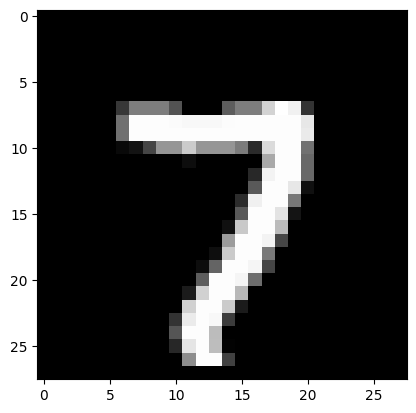

Prediction: 6
Label:      6
Entropy:   2.6932


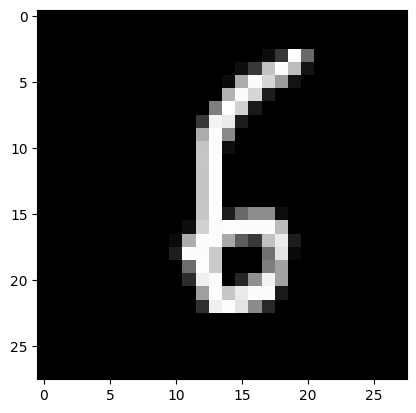

Prediction: 1
Label:      1
Entropy:   0.3977


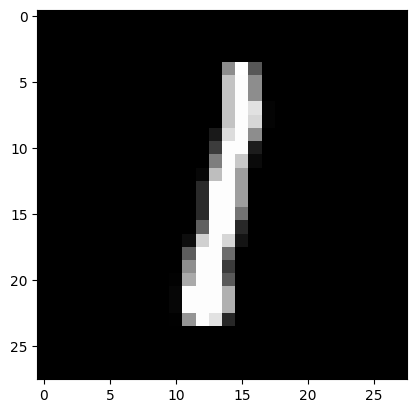

Prediction: 0
Label:      0
Entropy:   1.9246


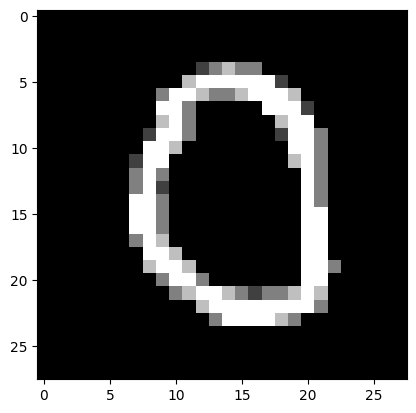

In [20]:
test_prediction(0, params)
test_prediction(1, params)
test_prediction(2, params)
test_prediction(3, params)